<a href="https://colab.research.google.com/github/Kuzay3t/Loan-Predictor/blob/main/Loan_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Overview
This is to build a supervised machine learning system that predicts whether a loan applicant should be approved (1) or rejected (0) based on their financial and personal information. The system:

Takes applicant data (income, credit score, employment status, etc.)

Processes and analyzes the data

Makes a prediction with a confidence score

Explains the decision (using SHAP values)


In [1]:
# importing necessary libaries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# uploading the dataset to be used
from google.colab import files
file = files.upload()

Saving loan_data.csv to loan_data.csv


In [5]:
#reading dataset

df = pd.read_csv('loan_data.csv')

## **Data Exploration and Preprocessing**

**What it does**:

Loads the loan application dataset

Shows dataset structure (columns, data types)

Displays first few rows to understand the data format

**Key Purpose**: Understand what data we're working with before processing it.

In [6]:
print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    int64  
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(3), int64(2), object(8)
memory usage: 38.8+ KB
None
    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001003   Male     Yes          1 

## **Handling Missing Values**
**What it does**:

Fills empty "Dependents" with '0'

Sets missing "Self_Employed" to 'No'

Replaces missing loan amounts with the median value

**Why it matters**: Machine learning models can't handle missing values, so we need to clean the data first.

In [8]:
print(df.isnull().sum())


Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


In [9]:
# Fill missing values
df['Dependents'] = df['Dependents'].fillna('0')
df['Self_Employed'] = df['Self_Employed'].fillna('No')
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].median())
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])

In [10]:
# Verify no more missing values
print(df.isnull().sum().sum())

0


## **Feature Engineering**
**What it does**:

Creates new features that might better predict loan eligibility:

TotalIncome: Combined income of applicant and co-applicant

EMI: Estimated monthly payment (assuming 9% interest)

BalanceIncome: Remaining income after EMI payments

**Why it matters**: These derived features often provide better signals than raw data alone.

In [11]:
# Create TotalIncome feature
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Create EMI feature (assuming 9% interest rate)
df['EMI'] = df['LoanAmount'] * 0.09 * (1 + 0.09)**df['Loan_Amount_Term'] / ((1 + 0.09)**df['Loan_Amount_Term'] - 1)

# Create BalanceIncome feature
df['BalanceIncome'] = df['TotalIncome'] - df['EMI']

# Convert Loan_Status to binary (Y=1, N=0)
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

##  Data Visualization
 *What it does*:

Creates visualizations to understand:

Income distributions

How approval rates vary by credit history, education, etc.

**Why it matters**: Helps identify patterns and important features before modeling.

Feature Encoding and Scaling

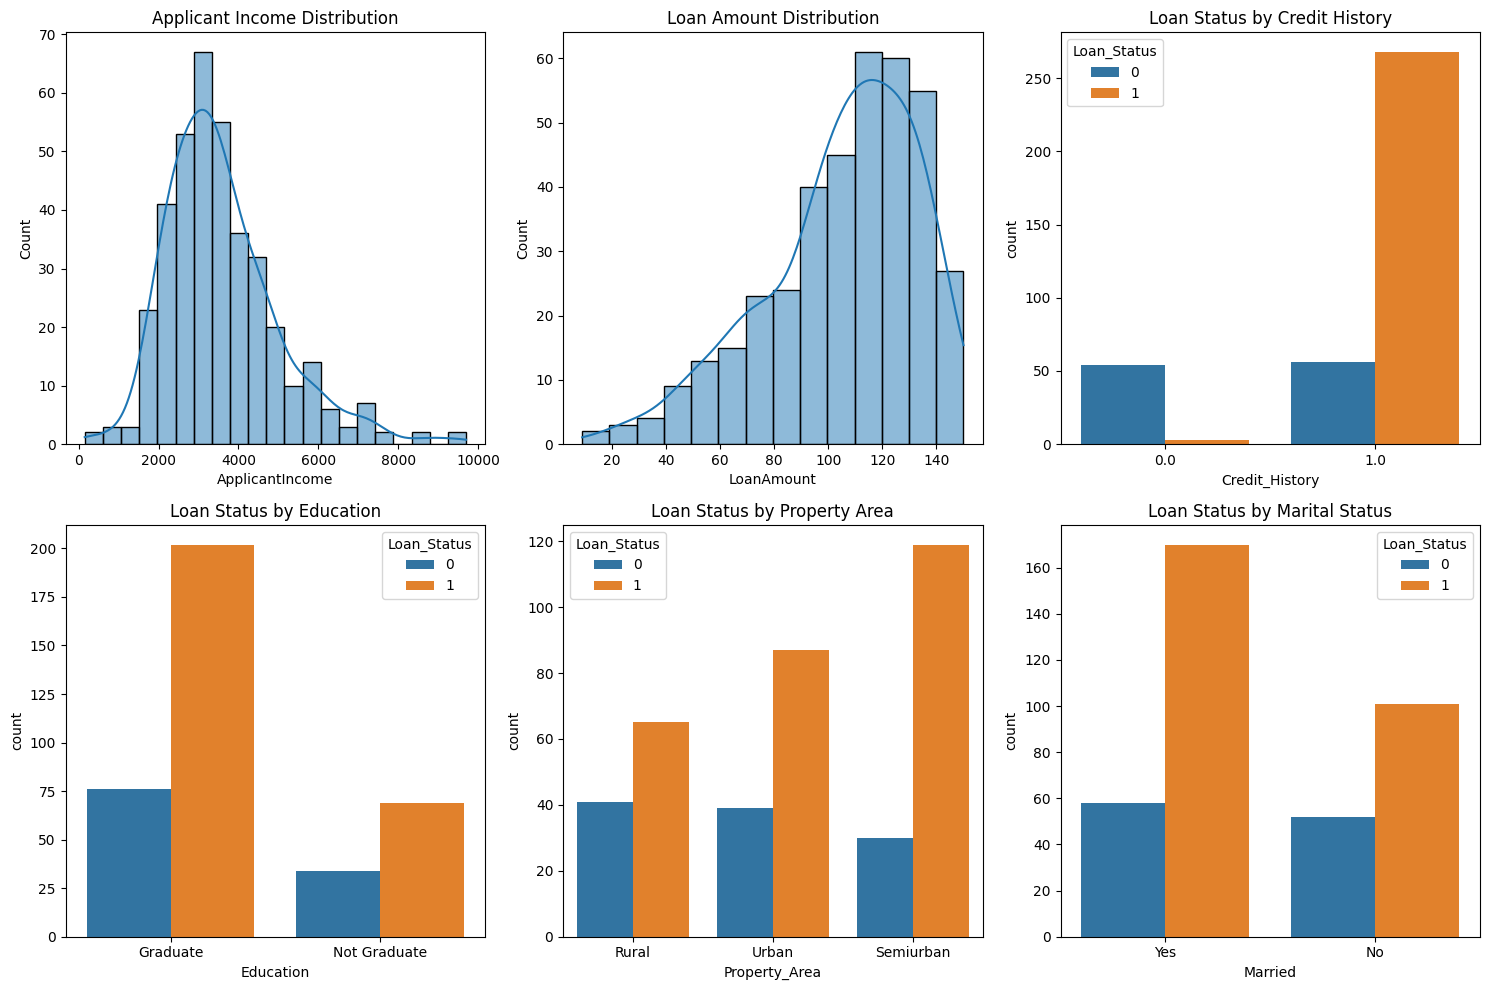

In [12]:
# Plot distributions
plt.figure(figsize=(15, 10))

plt.subplot(2,3,1)
sns.histplot(df['ApplicantIncome'], kde=True)
plt.title('Applicant Income Distribution')

plt.subplot(2,3,2)
sns.histplot(df['LoanAmount'], kde=True)
plt.title('Loan Amount Distribution')

plt.subplot(2,3,3)
sns.countplot(x='Credit_History', hue='Loan_Status', data=df)
plt.title('Loan Status by Credit History')

plt.subplot(2,3,4)
sns.countplot(x='Education', hue='Loan_Status', data=df)
plt.title('Loan Status by Education')

plt.subplot(2,3,5)
sns.countplot(x='Property_Area', hue='Loan_Status', data=df)
plt.title('Loan Status by Property Area')

plt.subplot(2,3,6)
sns.countplot(x='Married', hue='Loan_Status', data=df)
plt.title('Loan Status by Marital Status')

plt.tight_layout()
plt.show()

##  Feature Encoding and Scaling
*What it does*:

Converts text categories (like "Male"/"Female") to numbers (0/1)

Scales numerical features to similar ranges (mean=0, std=1)

*Why it matters* :

Models need numerical inputs

Scaling prevents features with larger ranges from dominating

In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                  'TotalIncome', 'EMI', 'BalanceIncome']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Drop unnecessary columns
df = df.drop(['Loan_ID'], axis=1)

## **Train-Test Split**
*What it does*:

Separates data into:

Training set (80%): For teaching the model

Test set (20%): For evaluating performance

*Why it matters*: We need unseen data to properly evaluate the model's real-world performance.

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **Model Building**
*What it does*:

Creates a Random Forest model (multiple decision trees combined)

Trains it on our data

Makes predictions on test data

*Why Random Forest?* :

Handles mixed data types well

Provides feature importance

Generally good performance with default settings

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(probability=True)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob)
    }

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T
print(results_df)

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.857143   0.833333  1.000000  0.909091  0.722314
Decision Tree        0.779221   0.827586  0.872727  0.849558  0.709091
Random Forest        0.883117   0.859375  1.000000  0.924370  0.825620
Gradient Boosting    0.870130   0.857143  0.981818  0.915254  0.789256
SVM                  0.857143   0.833333  1.000000  0.909091  0.785950


##  Model Evaluation
**What it does**:

Measures how often predictions are correct (accuracy)

Shows breakdown of correct/incorrect approvals/rejections

**Why it matter**s: We need to know if the model is making good predictions before using it.

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate the best model
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.8571428571428571
ROC AUC: 0.8099173553719008


## **Feature Importance**

**What it does**:

Identifies which features most influence the predictions

Ranks them by importance

**Why it matters**: Helps understand what factors drive loan decisions, which is crucial for:

Explaining decisions to applicants

Regulatory compliance

Improving the application process

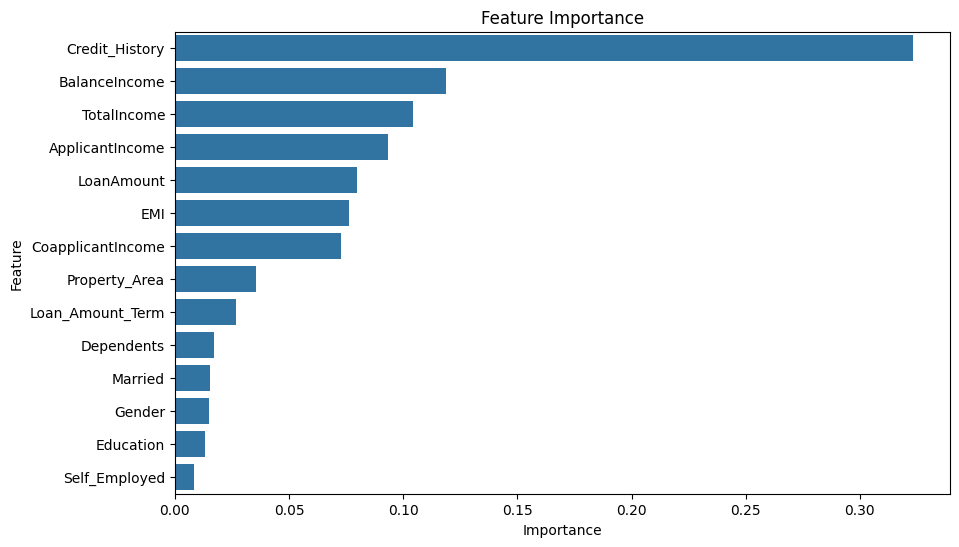

In [17]:
# Get feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

## **Model Interpretation (SHAP)**

**What it does**:

Shows how each feature contributes to individual predictions

Visualizes whether features push toward approval or rejection

**Why it matters**: Provides transparent explanations for each decision, which is critical in financial applications.

  0%|          | 0/77 [00:00<?, ?it/s]

Shape of shap_values: (77, 14, 2)
Shape of shap_values[1]: (14, 2)
Shape of X_test: (77, 14)


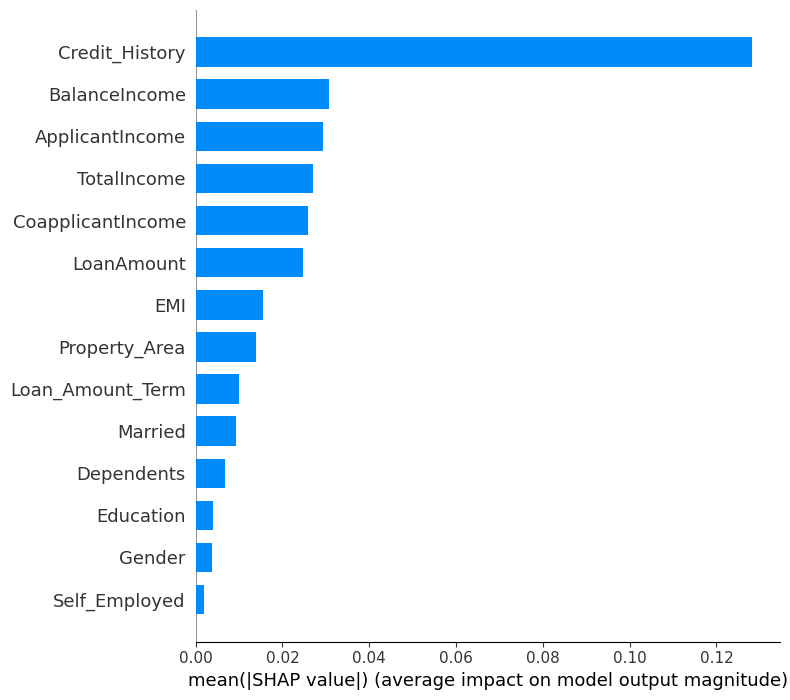

In [28]:
import shap
import numpy as np

# Create SHAP explainer using shap.KernelExplainer
# Use predict_proba for probability outputs in binary classification
explainer = shap.KernelExplainer(best_rf.predict_proba, shap.sample(X_train, 50)) # Using a sample of X_train as background data

# Calculate SHAP values for the test set
# KernelExplainer returns values with shape (n_samples, n_features, n_classes) for predict_proba
shap_values = explainer.shap_values(X_test)

# Print shapes for debugging
print("Shape of shap_values:", np.shape(shap_values))
print("Shape of shap_values[1]:", np.shape(shap_values[1])) # This print is now misleading, but kept for comparison with previous output
print("Shape of X_test:", np.shape(X_test))


# Plot summary plot, selecting SHAP values for the positive class (index 1) across all samples
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar")

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Define categorical and numerical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
                     'Loan_Amount_Term', 'Credit_History', 'TotalIncome', 'EMI', 'BalanceIncome']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', LabelEncoder())])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Create final pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**grid_search.best_params_))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print("Pipeline Accuracy:", accuracy_score(y_test, y_pred))

TypeError: LabelEncoder.fit_transform() takes 2 positional arguments but 3 were given

In [29]:
import joblib

# Save the pipeline
joblib.dump(pipeline, 'loan_approval_pipeline.pkl')

# Save the label encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

## **Prediction Pipeline**
Packages all preprocessing and modeling steps

Provides clean interface for making predictions

Why it matters: Makes the model usable in real applications with minimal code.

In [30]:
def predict_loan_eligibility(input_data):
    """
    Predict loan eligibility based on input data

    Args:
    input_data (dict): Dictionary containing applicant information

    Returns:
    dict: Prediction and probability
    """
    # Load the saved pipeline and label encoders
    pipeline = joblib.load('loan_approval_pipeline.pkl')
    label_encoders = joblib.load('label_encoders.pkl')

    # Convert input data to DataFrame
    input_df = pd.DataFrame([input_data])

    # Preprocess categorical variables using saved label encoders
    for col in categorical_cols:
        if col in input_df.columns:
            le = label_encoders[col]
            input_df[col] = le.transform(input_df[col])

    # Make prediction
    prediction = pipeline.predict(input_df)[0]
    probability = pipeline.predict_proba(input_df)[0][1]

    return {
        'eligible': bool(prediction),
        'probability': float(probability),
        'message': 'Approved' if prediction else 'Not Approved'
    }

# Example usage
sample_input = {
    'Gender': 'Male',
    'Married': 'Yes',
    'Dependents': '0',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 5000,
    'CoapplicantIncome': 2000,
    'LoanAmount': 120,
    'Loan_Amount_Term': 360,
    'Credit_History': 1,
    'Property_Area': 'Urban'
}

print(predict_loan_eligibility(sample_input))

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'